# **7 Exploring Hyperparameters (Activation Functions and Optimizers)**

This notebook presents the full experiments and detailed explanations, a separate short report is provided for verview and summarized findings for quick reference 🫶

https://docs.google.com/document/d/1xooevT-cFSf_KdIUuwUa3q0J7hTlSTKCrooyD6Q2g7g/edit?usp=sharing 

## **Importing Librariess**

In [ ]:
# Core scientific computing and data manipulation libraries
import numpy as np
import pandas as pd

# PyTorch for deep learning
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Torchvision for dataset and transforms
from torchvision.datasets import ImageFolder
from torchvision import transforms

# Data loading utilities
from torch.utils.data import DataLoader, Dataset, Subset

# File system and utilities
import os
import random
from collections import Counter
import cv2

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Progress bar
from tqdm import tqdm

# Kaggle integration
import kagglehub

## **Data Preparation**

### **Dataset Overview**

**Dataset Name:** Fracture Detection Using X-Ray Images  
**Source:** [Kaggle - devbatrax/fracture-detection-using-x-ray-images](https://www.kaggle.com/datasets/devbatrax/fracture-detection-using-x-ray-images)  

**Dataset Description:**
This dataset contains X-ray images used to train and evaluate deep learning models for bone fracture detection. The images are collected from various anatomical regions and labeled to indicate whether a fracture is present or not.

**Dataset Size:**

* Approximately **4,000+ X-ray images**
* Stored in multiple folders organized by class

**Number of Classes:**

* **2 classes:**

  * **Fractured**
  * **Normal (Non-fractured)**

**Goal:**
To develop and evaluate a computer vision model capable of accurately distinguishing fractured bones from normal X-rays for automated medical screening applications.

In [ ]:
# Download Dataset
path = kagglehub.dataset_download("devbatrax/fracture-detection-using-x-ray-images")
print("Path to dataset files:", path)

100%|██████████| 172M/172M [00:04<00:00, 44.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/devbatrax/fracture-detection-using-x-ray-images/versions/1


### **Preprocessing and Augmentation**

This code builds a **custom PyTorch dataset** for the X-ray fracture detection task—super neat because it automatically reads images, assigns labels based on folder names, and applies key preprocessing and augmentation steps

Each step in the preprocessing pipeline serves a special purpose suited for medical X-ray images:

* **Resize(128×128):** Standardizes image dimensions so all inputs are consistent for the model, improving training stability
* **RandomRotation(10):** Slight rotations mimic variations in how X-rays are taken, helping the model handle different orientations
* **RandomHorizontalFlip(0.2):** Simulates left–right differences in X-rays, enhancing the model’s ability to generalize across patients.
* **Normalize((0.5,), (0.5,)):** Centers pixel values for faster, more stable training and better contrast handling in grayscale medical images.


In [ ]:
# Custom Dataset Definition
class FractureDataset(Dataset):
    def __init__(self, root, transforms=None):
        self.image_paths = []
        self.labels = []
        self.class_map = {}

        # Detect subfolders as classes
        classes = sorted(os.listdir(root))
        self.class_map = {cls_name: idx for idx, cls_name in enumerate(classes)}

        # Collect image paths and labels
        for cls_name in classes:
            cls_folder = os.path.join(root, cls_name)
            for file_name in os.listdir(cls_folder):
                img_path = os.path.join(cls_folder, file_name)
                if os.path.isfile(img_path): # Added a check to ensure it's a file
                    self.image_paths.append(img_path)
                    self.labels.append(self.class_map[cls_name])

        self.transforms = transforms

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # Read image as grayscale
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if self.transforms:
            # Convert to PIL Image
            img = transforms.ToPILImage()(img)
            img = self.transforms(img)
        return img, label

    def __len__(self):
        return len(self.image_paths)

In [ ]:
# Preprocessing and Augmentation
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


### **Train and Test Set**

This section creates and prepares the training and testing datasets for the fracture detection model. It first loads the images from their respective folders, applies preprocessing and augmentation, and then analyzes the class distribution.

In [ ]:
# Create Datasets
train_dir = os.path.join(path, 'data/train')
test_dir = os.path.join(path, 'data/val')

train_dataset = FractureDataset(root=train_dir, transforms=transform)
test_dataset = FractureDataset(root=test_dir, transforms=transform)

print(f"Number of training images: {len(train_dataset)}")
print(f"Number of testing images: {len(test_dataset)}")
print(f"Class mapping: {train_dataset.class_map}")

Number of training images: 8863
Number of testing images: 600
Class mapping: {'fractured': 0, 'not fractured': 1}


In [ ]:
# Dataset Statistics
def print_class_distribution(name, labels, class_map):
    counter = Counter(labels)
    print(f"\n {name} Set Class Distribution:")
    for cls_name, idx in class_map.items():
        print(f"  Class {idx} ({cls_name}): {counter[idx]} images")

print_class_distribution("Training", train_dataset.labels, train_dataset.class_map)
print_class_distribution("Testing", test_dataset.labels, test_dataset.class_map)



 Training Set Class Distribution:
  Class 0 (fractured): 4480 images
  Class 1 (not fractured): 4383 images

 Testing Set Class Distribution:
  Class 0 (fractured): 360 images
  Class 1 (not fractured): 240 images


### **Balance Dataset**

Since the classes are imbalance (e.g., more normal X-rays than fracture cases), an oversampling technique is applied to ensure each class has an equal number of samples.

In [ ]:
# Balance datasets by oversampling
def balance_dataset(dataset):
    """
    Oversample minority classes so that all classes have equal counts.
    Returns a balanced Subset of the original dataset.
    """

    labels = np.array(dataset.labels)
    class_indices = {cls: np.where(labels == cls)[0] for cls in np.unique(labels)}

    # Find the largest class count (target count)
    max_count = max(len(idxs) for idxs in class_indices.values())

    # Oversample minority classes
    balanced_indices = np.concatenate([
        np.random.choice(idxs, max_count, replace=True)  # replace=True to allow duplication
        for idxs in class_indices.values()
    ])
    np.random.shuffle(balanced_indices)

    return Subset(dataset, balanced_indices), max_count


# Apply balancing
train_dataset, train_max_count = balance_dataset(train_dataset)
test_dataset, test_max_count = balance_dataset(test_dataset)

# Print summary
print("\nBalanced Dataset Summary (Oversampled):")
for cls_name, idx in train_dataset.dataset.class_map.items():
    print(f"  Training - Class {idx} ({cls_name}): {train_max_count} samples")
for cls_name, idx in test_dataset.dataset.class_map.items():
    print(f"  Testing  - Class {idx} ({cls_name}): {test_max_count} samples")

print(f"\nTotal training samples: {len(train_dataset)}")
print(f"Total testing samples: {len(test_dataset)}")



Balanced Dataset Summary (Oversampled):
  Training - Class 0 (fractured): 4480 samples
  Training - Class 1 (not fractured): 4480 samples
  Testing  - Class 0 (fractured): 360 samples
  Testing  - Class 1 (not fractured): 360 samples

Total training samples: 8960
Total testing samples: 720


### **Create DataLoaders**

A random seed is set to ensure reproducibility of results, and DataLoaders are created to efficiently batch, shuffle, and load data in parallel for faster and consistent model training and testing.

In [ ]:
# Sets random seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
# Set random seed for reproducibility
set_seed(42)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

print("DataLoaders created successfully.")


DataLoaders created successfully.


### **Visualize Dataset**

Fetching batch:   0%|          | 0/560 [00:00<?, ?it/s]


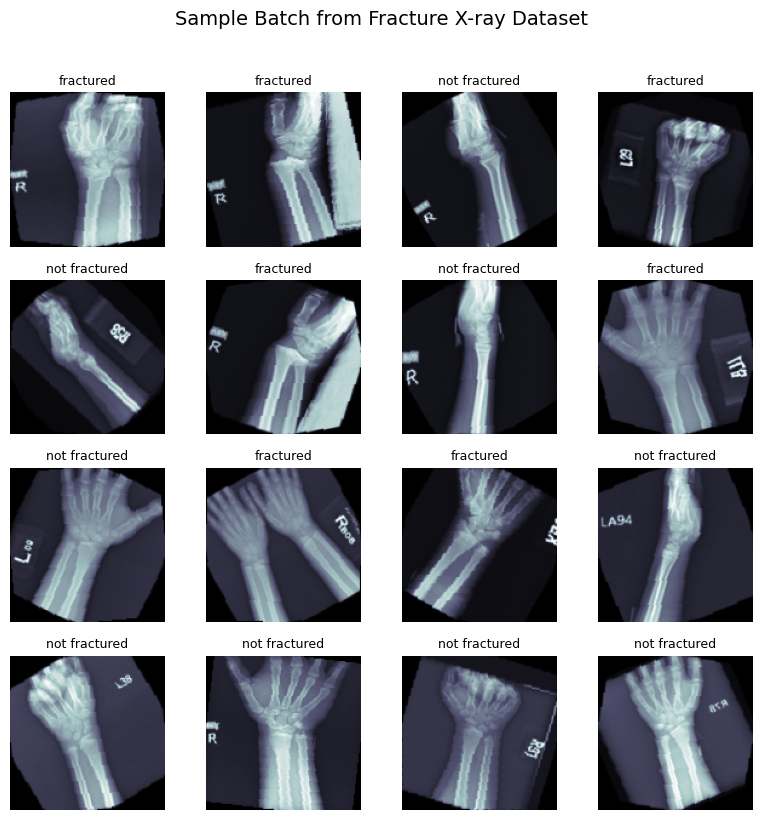

In [ ]:
# Use tqdm to iterate over DataLoader
for batch in tqdm(train_loader, desc="Fetching batch"):
    images, labels = batch
    break  # only take the first batch

# Determine how many images to display
num_images = min(16, images.size(0))
cols = 4
rows = (num_images + cols - 1) // cols

# Reverse class mapping (index → class name)
# Access the class_map from the original dataset within the Subset
idx_to_class = {v: k for k, v in train_dataset.dataset.class_map.items()}

# Plot grid of sample images
plt.figure(figsize=(8, 2 * rows))
for i in range(num_images):
    plt.subplot(rows, cols, i + 1)
    img = images[i].permute(1, 2, 0)  # convert (C,H,W) → (H,W,C)
    # For grayscale images, remove the last dimension
    if img.shape[-1] == 1:
        img = img.squeeze(-1)
    plt.imshow(img, cmap='bone')  # 'bone' colormap suits X-rays
    plt.title(f"{idx_to_class[labels[i].item()]}", fontsize=9)
    plt.axis('off')

plt.suptitle("Sample Batch from Fracture X-ray Dataset", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## **Create CNN Model**

The **XrayCNN** model is a custom-built **Convolutional Neural Network (CNN)** designed for **binary classification** of X-ray images (fracture vs. normal). It consists of two main **feature extraction blocks** using convolution, batch normalization, activation (SiLU), pooling, and dropout layers to learn spatial and texture patterns from the images. The **classification head** then flattens these features and passes them through fully connected layers to produce final predictions using a **LogSoftmax** output.

### **Why SiLU Activation**

The **SiLU (Sigmoid Linear Unit)** activation function—mathematically equivalent to the **Swish** function $(f(x) = x \cdot \sigma(x))$ was selected over conventional activations like ReLU due to its smooth and non-monotonic characteristics. Unlike ReLU, which sharply discards negative inputs, SiLU gradually suppresses them, allowing the network to retain subtle information from small negative activations. This results in smoother gradient flow and improved generalization. Such behavior is particularly beneficial in **medical X-ray image analysis**, where critical diagnostic features often appear as fine-grained intensity variations rather than sharp contrasts. The SiLU’s ability to model these nuanced patterns makes it more effective for detecting subtle anomalies in medical imaging ([Ramachandran, Zoph, & Le, 2017](https://arxiv.org/abs/1710.05941)).


In [ ]:
class XrayCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(XrayCNN, self).__init__()

        # === Feature Extraction Block 1 ===
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.10)

        # === Feature Extraction Block 2 ===
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.15)

        # === Classification Head ===
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 32 * 32, 128)
        self.dropout3 = nn.Dropout(0.6)
        self.fc2 = nn.Linear(128, num_classes)

        # Activation
        self.act = nn.SiLU()

        # LogSoftmax layer
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # --- Block 1 ---
        x = self.act(self.bn1(self.conv1(x)))
        x = self.pool1(self.act(self.bn2(self.conv2(x))))
        x = self.dropout1(x)

        # --- Block 2 ---
        x = self.pool2(self.act(self.bn3(self.conv3(x))))
        x = self.dropout2(x)

        # --- Classification ---
        x = self.flatten(x)
        x = self.dropout3(self.act(self.fc1(x)))
        x = self.fc2(x)

        # Log probabilities
        x = self.log_softmax(x)
        return x


# Verify the model
model = XrayCNN(num_classes=2)
print(model)

# Test forward pass
sample = torch.randn(1, 1, 128, 128)
output = model(sample)
print("Output shape:", output.shape)  # Expected: [1, 2]
print("Log probabilities:", output)


XrayCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.1, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.15, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=131072, out_features=128, bias=True)
  (dropout3): Dropout(p=0.6, inplace=False)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
  (act): SiLU()


## **Model Training and Experimentation**

In this experiment, the **XrayCNN** model was trained and evaluated across five different optimizers. Each optimizer was tested under the same settings **20 epochs**, **batch size of 16**, and a **learning rate of 0.001** to determine which combination provides the most stable and accurate convergence.

| **Component**           | **Description**                       |
| ----------------------- | ------------------------------------- |
| **Epochs**              | 20                                    |
| **Batch Size**          | 16                                    |
| **Loss Function**       | CrossEntropyLoss                      |
| **Activation Function** | SiLU                                  |
| **Optimizers Tested**   | SGD, Adagrad, Adadelta, Adam, RMSProp |
| **Learning Rate**       | 0.001 for all optimizers              |


In [ ]:
# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 20
batch_size = 16

# Use previously balanced DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Loss function
criterion = nn.CrossEntropyLoss()


In [ ]:
# Define optimizers to test
optimizer_dict = {
    "SGD": lambda params: optim.SGD(params, lr=0.001),
    "Adagrad": lambda params: optim.Adagrad(params, lr=0.001),
    "Adadelta": lambda params: optim.Adadelta(params, lr=0.001),
    "Adam": lambda params: optim.Adam(params, lr=0.001),
    "RMSProp": lambda params: optim.RMSprop(params, lr=0.001)
}

In [ ]:
# Train and evaluate model
def train_and_evaluate(model, optimizer_func, num_epochs, train_loader, test_loader, criterion):
    optimizer = optimizer_func(model.parameters())
    train_losses, train_accs = [], []

    # --- Training loop ---
    for epoch in range(num_epochs):
        print(f"\nEpoch [{epoch+1}/{num_epochs}]")
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        train_bar = tqdm(train_loader, desc="Training", leave=False)

        for images, labels in train_bar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            train_bar.set_postfix({"Loss": running_loss / total, "Acc": correct / total})

        train_loss = running_loss / total
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

    # --- Evaluate once on test set ---
    print("\nEvaluating on test set...")
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss = running_loss / total
    test_acc = correct / total

    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

    return train_losses, train_accs, test_loss, test_acc


In [ ]:
# Run experiments per optimizer
results = {}

for name, opt_func in optimizer_dict.items():
    print(f"\n=== Training with {name} ===")

    # Re-seed to ensure identical starting point for each optimizer experiment
    set_seed(42)

    model = XrayCNN(num_classes=2).to(device)
    train_losses, train_accs, test_loss, test_acc = train_and_evaluate(
        model, opt_func, num_epochs, train_loader, test_loader, criterion
    )

    results[name] = {
        "train_loss": train_losses,
        "test_loss": test_loss,
        "train_acc": train_accs,
        "test_acc": test_acc
    }



=== Training with SGD ===

Epoch [1/20]


Train Loss: 0.6199, Train Acc: 0.6509

Epoch [2/20]


Train Loss: 0.5225, Train Acc: 0.7354

Epoch [3/20]


Train Loss: 0.4435, Train Acc: 0.7891

Epoch [4/20]


Train Loss: 0.3875, Train Acc: 0.8254

Epoch [5/20]


Train Loss: 0.3226, Train Acc: 0.8629

Epoch [6/20]


Train Loss: 0.2946, Train Acc: 0.8778

Epoch [7/20]


Train Loss: 0.2687, Train Acc: 0.8910

Epoch [8/20]


Train Loss: 0.2376, Train Acc: 0.9066

Epoch [9/20]


Train Loss: 0.2119, Train Acc: 0.9182

Epoch [10/20]


Train Loss: 0.1757, Train Acc: 0.9329

Epoch [11/20]


Train Loss: 0.1761, Train Acc: 0.9376

Epoch [12/20]


Train Loss: 0.1583, Train Acc: 0.9422

Epoch [13/20]


Train Loss: 0.1451, Train Acc: 0.9469

Epoch [14/20]


Train Loss: 0.1350, Train Acc: 0.9511

Epoch [15/20]


Train Loss: 0.1363, Train Acc: 0.9512

Epoch [16/20]


Train Loss: 0.1253, Train Acc: 0.9536

Epoch [17/20]


Train Loss: 0.1119, Train Acc: 0.9615

Epoch [18/20]


Train Loss: 0.1135, Train Acc: 0.9592

Epoch [19/20]


Train Loss: 0.0973, Train Acc: 0.9664

Epoch [20/20]


Train Loss: 0.1071, Train Acc: 0.9636

Evaluating on test set...


Test Loss: 0.7264, Test Acc: 0.7125

=== Training with Adagrad ===

Epoch [1/20]


Train Loss: 0.7867, Train Acc: 0.6407

Epoch [2/20]


Train Loss: 0.5144, Train Acc: 0.7249

Epoch [3/20]


Train Loss: 0.4551, Train Acc: 0.7605

Epoch [4/20]


Train Loss: 0.3991, Train Acc: 0.8035

Epoch [5/20]


Train Loss: 0.3516, Train Acc: 0.8410

Epoch [6/20]


Train Loss: 0.3078, Train Acc: 0.8577

Epoch [7/20]


Train Loss: 0.2768, Train Acc: 0.8785

Epoch [8/20]


Train Loss: 0.2520, Train Acc: 0.8923

Epoch [9/20]


Train Loss: 0.2324, Train Acc: 0.8989

Epoch [10/20]


Train Loss: 0.2128, Train Acc: 0.9141

Epoch [11/20]


Train Loss: 0.1972, Train Acc: 0.9259

Epoch [12/20]


Train Loss: 0.1838, Train Acc: 0.9248

Epoch [13/20]


Train Loss: 0.1709, Train Acc: 0.9320

Epoch [14/20]


Train Loss: 0.1566, Train Acc: 0.9392

Epoch [15/20]


Train Loss: 0.1488, Train Acc: 0.9416

Epoch [16/20]


Train Loss: 0.1412, Train Acc: 0.9452

Epoch [17/20]


Train Loss: 0.1416, Train Acc: 0.9459

Epoch [18/20]


Train Loss: 0.1330, Train Acc: 0.9499

Epoch [19/20]


Train Loss: 0.1185, Train Acc: 0.9556

Epoch [20/20]


Train Loss: 0.1203, Train Acc: 0.9545

Evaluating on test set...


Test Loss: 0.5321, Test Acc: 0.7611

=== Training with Adadelta ===

Epoch [1/20]


Train Loss: 0.6085, Train Acc: 0.6607

Epoch [2/20]


Train Loss: 0.5297, Train Acc: 0.7287

Epoch [3/20]


Train Loss: 0.4881, Train Acc: 0.7647

Epoch [4/20]


Train Loss: 0.4459, Train Acc: 0.7972

Epoch [5/20]


Train Loss: 0.4140, Train Acc: 0.8206

Epoch [6/20]


Train Loss: 0.3804, Train Acc: 0.8348

Epoch [7/20]


Train Loss: 0.3526, Train Acc: 0.8541

Epoch [8/20]


Train Loss: 0.3348, Train Acc: 0.8656

Epoch [9/20]


Train Loss: 0.3175, Train Acc: 0.8753

Epoch [10/20]


Train Loss: 0.2973, Train Acc: 0.8879

Epoch [11/20]


Train Loss: 0.2819, Train Acc: 0.8920

Epoch [12/20]


Train Loss: 0.2628, Train Acc: 0.9020

Epoch [13/20]


Train Loss: 0.2482, Train Acc: 0.9084

Epoch [14/20]


Train Loss: 0.2348, Train Acc: 0.9129

Epoch [15/20]


Train Loss: 0.2286, Train Acc: 0.9157

Epoch [16/20]


Train Loss: 0.2196, Train Acc: 0.9234

Epoch [17/20]


Train Loss: 0.2092, Train Acc: 0.9244

Epoch [18/20]


Train Loss: 0.2042, Train Acc: 0.9285

Epoch [19/20]


Train Loss: 0.1982, Train Acc: 0.9323

Epoch [20/20]


Train Loss: 0.1845, Train Acc: 0.9376

Evaluating on test set...


Test Loss: 0.4562, Test Acc: 0.7833

=== Training with Adam ===

Epoch [1/20]


Train Loss: 0.8979, Train Acc: 0.5871

Epoch [2/20]


Train Loss: 0.6322, Train Acc: 0.6241

Epoch [3/20]


Train Loss: 0.6169, Train Acc: 0.6350

Epoch [4/20]


Train Loss: 0.6152, Train Acc: 0.6401

Epoch [5/20]


Train Loss: 0.6085, Train Acc: 0.6456

Epoch [6/20]


Train Loss: 0.5885, Train Acc: 0.6710

Epoch [7/20]


Train Loss: 0.5829, Train Acc: 0.6717

Epoch [8/20]


Train Loss: 0.5713, Train Acc: 0.6837

Epoch [9/20]


Train Loss: 0.5632, Train Acc: 0.6955

Epoch [10/20]


Train Loss: 0.5474, Train Acc: 0.7088

Epoch [11/20]


Train Loss: 0.5545, Train Acc: 0.7081

Epoch [12/20]


Train Loss: 0.5392, Train Acc: 0.7138

Epoch [13/20]


Train Loss: 0.5337, Train Acc: 0.7249

Epoch [14/20]


Train Loss: 0.5189, Train Acc: 0.7393

Epoch [15/20]


Train Loss: 0.5139, Train Acc: 0.7452

Epoch [16/20]


Train Loss: 0.4992, Train Acc: 0.7541

Epoch [17/20]


Train Loss: 0.5005, Train Acc: 0.7497

Epoch [18/20]


Train Loss: 0.4770, Train Acc: 0.7722

Epoch [19/20]


Train Loss: 0.4748, Train Acc: 0.7789

Epoch [20/20]


Train Loss: 0.4647, Train Acc: 0.7825

Evaluating on test set...


Test Loss: 2.9322, Test Acc: 0.6764

=== Training with RMSProp ===

Epoch [1/20]


Train Loss: 2.1416, Train Acc: 0.5936

Epoch [2/20]


Train Loss: 0.7008, Train Acc: 0.5996

Epoch [3/20]


Train Loss: 0.6537, Train Acc: 0.6087

Epoch [4/20]


Train Loss: 0.6544, Train Acc: 0.6169

Epoch [5/20]


Train Loss: 0.6476, Train Acc: 0.6375

Epoch [6/20]


Train Loss: 0.6590, Train Acc: 0.6432

Epoch [7/20]


Train Loss: 0.6042, Train Acc: 0.6656

Epoch [8/20]


Train Loss: 0.5804, Train Acc: 0.6787

Epoch [9/20]


Train Loss: 0.5647, Train Acc: 0.7001

Epoch [10/20]


Train Loss: 0.5405, Train Acc: 0.7186

Epoch [11/20]


Train Loss: 0.5251, Train Acc: 0.7431

Epoch [12/20]


Train Loss: 0.5172, Train Acc: 0.7471

Epoch [13/20]


Train Loss: 0.4928, Train Acc: 0.7584

Epoch [14/20]


Train Loss: 0.4687, Train Acc: 0.7773

Epoch [15/20]


Train Loss: 0.4836, Train Acc: 0.7913

Epoch [16/20]


Train Loss: 0.4475, Train Acc: 0.7982

Epoch [17/20]


Train Loss: 0.4279, Train Acc: 0.8129

Epoch [18/20]


Train Loss: 0.4104, Train Acc: 0.8174

Epoch [19/20]


Train Loss: 0.4150, Train Acc: 0.8232

Epoch [20/20]


Train Loss: 0.3898, Train Acc: 0.8369

Evaluating on test set...


Test Loss: 0.4458, Test Acc: 0.7708


## **Results and Discussion**

In [ ]:
# Visualize Results
def plot_optimizer_results(results, optimizer_dict, num_epochs):
    epochs = range(1, num_epochs + 1)
    num_opts = len(optimizer_dict)
    fig, axes = plt.subplots(num_opts, 1, figsize=(10, 4 * num_opts)) # Changed to 1 column

    # Ensure axes is always an array for consistent indexing
    if num_opts == 1:
        axes = np.array([axes])

    fig.suptitle("Optimizer Comparison: Convergence of Loss and Accuracy", fontsize=16, y=1.02)

    for i, (name, metrics) in enumerate(results.items()):
        train_loss = metrics["train_loss"]
        test_loss = metrics["test_loss"]
        train_acc = metrics["train_acc"]
        test_acc = metrics["test_acc"]

        ax1 = axes[i] # Single axis per optimizer
        ax2 = ax1.twinx() # Create a second y-axis

        # --- Loss Plot ---
        ax1.plot(epochs, train_loss, label="Train Loss", color="tab:blue")
        ax1.plot(epochs[-1], test_loss, label="Test Loss", color="tab:orange", marker='o')
        ax1.set_xlabel("Epochs")
        ax1.set_ylabel("Loss", color="tab:blue")
        ax1.tick_params(axis='y', labelcolor="tab:blue")
        ax1.grid(True, linestyle="--", alpha=0.6)


        # --- Accuracy Plot ---
        ax2.plot(epochs, train_acc, label="Train Acc", color="tab:green")
        ax2.plot(epochs[-1], test_acc, label="Test Acc", color="tab:red", marker='o')
        ax2.set_ylabel("Accuracy", color="tab:green")
        ax2.tick_params(axis='y', labelcolor="tab:green")

        # --- Title and Legends ---
        ax1.set_title(f"{name} - Loss and Accuracy")
        # Combine legends and place outside the plot
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right', bbox_to_anchor=(1.25, 1))


        # Annotate final values
        ax1.annotate(f"{train_loss[-1]:.3f}", xy=(epochs[-1], train_loss[-1]),
                     xytext=(-40, 5), textcoords="offset points", color="tab:blue")
        ax1.annotate(f"{test_loss:.3f}", xy=(epochs[-1], test_loss),
                     xytext=(-40, -15), textcoords="offset points", color="tab:orange")
        ax2.annotate(f"{train_acc[-1]*100:.1f}%", xy=(epochs[-1], train_acc[-1]),
                     xytext=(-40, 5), textcoords="offset points", color="tab:green")
        ax2.annotate(f"{test_acc*100:.1f}%", xy=(epochs[-1], test_acc),
                     xytext=(-40, -15), textcoords="offset points", color="tab:red")


    plt.tight_layout()
    plt.show()

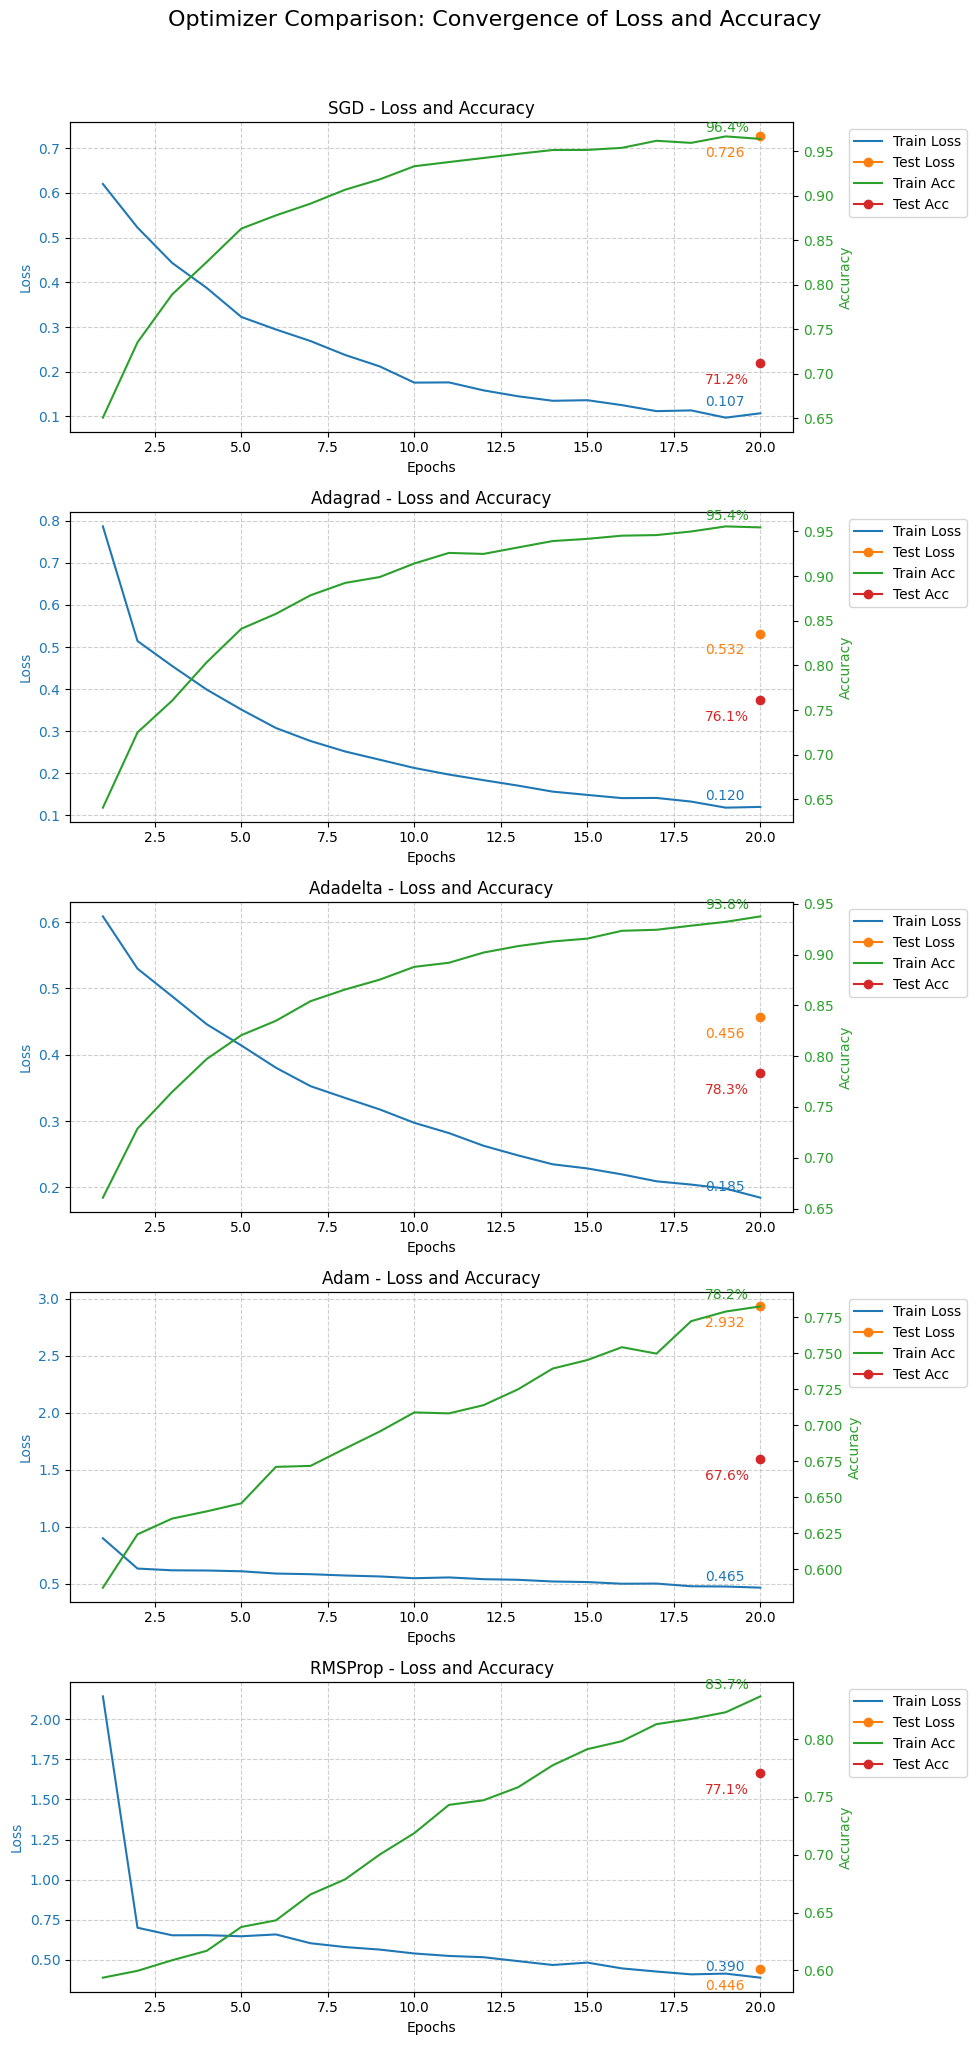

In [ ]:
# === Plot results ===
plot_optimizer_results(results, optimizer_dict, num_epochs)

### **Optimizer Convergence Analysis**

The convergence patterns of five optimizers—SGD, Adagrad, Adadelta, Adam, and RMSProp—were examined over 20 epochs based on their training and testing trends.

**SGD** exhibited rapid loss reduction during the first 8–10 epochs, but the gap between training and testing accuracy widened as training progressed. Its aggressive updates led to quick convergence yet unstable generalization, indicating overfitting.

**Adagrad** converged the fastest, reaching low loss within the first few epochs. However, the rapid decay of its adaptive learning rate caused early saturation, limiting further improvement and resulting in shallow convergence.

**Adadelta** showed smooth, gradual convergence throughout all epochs. Both training and testing losses decreased consistently, reflecting stable learning dynamics and sustained optimization across time.

**Adam** displayed fluctuating convergence behavior. The training curve stabilized early but with high loss values, while the test loss increased sharply, suggesting unstable gradient adaptation and inconsistent learning progress.

**RMSProp** converged rapidly within the initial five epochs and then plateaued. Although it maintained stable loss values, its early stabilization indicated limited refinement and a tendency toward premature convergence.

**Comparative Insight:**
Adadelta demonstrated the most balanced and consistent convergence among all optimizers, maintaining steady improvement across epochs. In contrast, RMSProp and Adagrad converged quickly but prematurely, while SGD and Adam showed unstable or overfitted learning patterns.


In [ ]:
# Create a list to hold the data for the DataFrame
data = []

for name, metrics in results.items():
    train_loss = metrics["train_loss"][-1] # Get the final training loss
    test_loss = metrics["test_loss"]
    train_acc = metrics["train_acc"][-1] # Get the final training accuracy
    test_acc = metrics["test_acc"]

    loss_diff = train_loss - test_loss
    acc_diff = train_acc - test_acc

    data.append({
        "Optimizer": name,
        "Final Train Loss": train_loss,
        "Final Test Loss": test_loss,
        "Loss Difference (Train - Test)": loss_diff,
        "Final Train Accuracy": train_acc,
        "Final Test Accuracy": test_acc,
        "Accuracy Difference (Train - Test)": acc_diff
    })

# Create the DataFrame
results_df = pd.DataFrame(data)

# Display the DataFrame
display(results_df)

,Optimizer,Final Train Loss,Final Test Loss,Loss Difference (Train - Test),Final Train Accuracy,Final Test Accuracy,Accuracy Difference (Train - Test)
0,SGD,0.107109,0.726397,-0.619288,0.963616,0.712500,0.251116
1,Adagrad,0.120303,0.532102,-0.411799,0.954464,0.761111,0.193353
2,Adadelta,0.184519,0.456157,-0.271638,0.937612,0.783333,0.154278
3,Adam,0.464731,2.932230,-2.467500,0.782478,0.676389,0.106089
4,RMSProp,0.389823,0.445818,-0.055995,0.836942,0.770833,0.066109


### **Generalization Analysis**

The generalization capability of each optimizer was evaluated by comparing final training and testing performance. A smaller difference between train and test results typically indicates consistent learning, but only when both accuracies are sufficiently high and the model has converged meaningfully.

**SGD** achieved the lowest training loss (0.107) and highest training accuracy (96.4%), but its test accuracy dropped sharply to 71.2%. The large 25.1% accuracy gap demonstrates overfitting: the optimizer aggressively minimized training error but failed to maintain performance on unseen data, consistent with its steep convergence curve.

**Adagrad** slightly improved generalization, narrowing the gap to 19.3%. However, its test accuracy (76.1%) remained limited because its adaptive learning rate decayed too quickly. This caused early saturation—rapid convergence but insufficient exploration of the loss surface—leading to partial underfitting.

**Adadelta** provided the most balanced generalization, achieving 93.8% training and 78.3% testing accuracy with a moderate 15.4% gap. Its smoother, slower convergence allowed continuous refinement of the model weights across epochs, enabling it to capture both broad and subtle data characteristics. The lower test loss (0.456) and steady accuracy curve confirm robust and stable generalization.

**Adam** showed the weakest generalization behavior. Despite converging early, its test loss (2.932) increased drastically, and both accuracies remained low. This inconsistency suggests unstable gradient adaptation and poor weight regularization, resulting in a model that neither fits the training data well nor generalizes effectively.

**RMSProp**, although producing the smallest accuracy gap (6.6%) and minimal loss difference (0.056), does not represent true generalization strength. The optimizer’s early plateau—observed in the convergence analysis—caused it to stop improving after capturing only surface-level patterns. The low overall accuracies (83.7% train, 77.1% test) indicate that the network underfit both sets rather than generalized effectively. In other words, its “small gap” reflects *limited learning depth*, not superior performance.

**Comparative Insight:**
Adadelta demonstrates the most effective generalization behavior. Unlike RMSProp, whose quick stabilization leads to shallow learning, Adadelta sustains gradual optimization, achieving both higher accuracy and lower loss across datasets. This confirms that early convergence does not equate to optimal generalization; the optimizer must also preserve learning momentum to extract finer discriminative features. Hence, Adadelta emerges as the most balanced and reliable optimizer for the model, combining convergence stability with robust generalization suitable for lightweight clinical deployment.


## **Summary and Conclusion**

### **Summary**

Based on the final performance metrics, the optimizers were ranked according to their ability to generalize to unseen data and sustain stable convergence throughout training.

1. **Best Overall Performer — Adadelta:**
   Achieved the highest **Test Accuracy (78.3%)** and low **Test Loss (0.456)**, reflecting strong and balanced generalization. Adadelta maintained steady learning across epochs, avoiding both overfitting and underfitting. Its adaptive update mechanism sustained gradient flow, allowing continuous improvement even after other optimizers had plateaued.

2. **Stable but Shallow Generalizer — RMSProp:**
   Recorded the **lowest Test Loss (0.446)** and the **smallest Accuracy Gap (6.6%)**, indicating consistent performance between training and testing. However, as established in the convergence analysis, this small difference resulted from **early plateauing** rather than superior learning. RMSProp converged rapidly but captured only surface-level patterns, leading to slightly lower final accuracy (77.1%) and limited learning depth.

3. **Moderate Generalizer — Adagrad:**
   Delivered respectable **test accuracy (76.1%)** but exhibited a notable **19.3% train–test gap**, signifying overfitting. The rapid decay of its learning rate restricted further optimization, causing early convergence and preventing it from refining deeper data representations.

4. **High Learner but Poor Generalizer — SGD:**
   Produced the **highest training accuracy (96.4%)** and **lowest training loss (0.107)**, but suffered from the **widest accuracy gap (25.1%)**. The model overfit heavily to the training data, leading to a steep **drop in test performance (71.3%)**. This behavior reflects SGD’s tendency to exploit sharp minima rather than broad, generalizable ones.

5. **Least Effective — Adam:**
   Demonstrated the weakest results overall, with **low training accuracy (78.2%)**, **poor test accuracy (67.6%)**, and **high test loss (2.932)**. The **small accuracy difference (10.6%)** was misleading since both scores were low, indicating underfitting and unstable convergence.

### **Conclusion**

Overall, **Adadelta emerged as the most effective optimizer**, combining smooth convergence with strong generalization and stable test performance. **RMSProp**, despite its minimal train–test gap, was limited by premature convergence and shallower learning. **Adagrad** and **SGD** showed faster but overfitted behaviors, while **Adam** failed to stabilize. These results confirm that **a smaller train–test gap does not inherently indicate superior generalization**—true performance depends on both the **quality of convergence** and the **depth of learning**. Adadelta best balances these factors, making it the most reliable and computationally efficient optimizer for the model.